# Семинар №2 по курсу "Классическое машинное обучение и распознавание образов"



In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from PIL import Image

from skimage import data, filters, exposure, transform, color
from skimage.transform import integral_image
from skimage.filters import gabor_kernel
from skimage.feature import Cascade, hog, haar_like_feature
from skimage.exposure import rescale_intensity

%matplotlib inline

# Методы сбора данных, ч.2. (Распознование образов)

## 1. Признаки Хаара


*Признаки Хаара* — признаки цифрового изображения, используемые в распознавании образов. Признаки Хаара использовались в первом детекторе лиц, работающем в реальном времени.

*Прямоугольные признаки Хаара* - простейший прямоугольный признак Хаара можно определить как разность сумм пикселей двух смежных областей внутри прямоугольника, который может занимать различные положения и масштабы на изображении. Каждый признак может показать наличие (или отсутствие) какой-либо конкретной характеристики изображения, такой как границы или изменение текстур. Например, 2-прямоугольный (2 области) признак может показать, где находится граница между темным и светлым регионами.

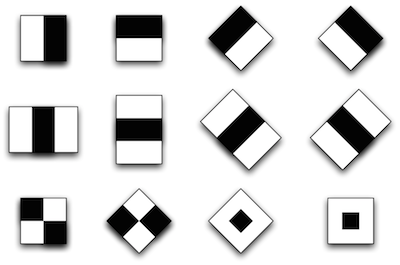

Признак на основе примитива Хаара расчитывается как разность интенсивностей "белой" и "черной" областей, также было предложено приписывать каждой подобласти определенный вес (wi) и значения признака вычислять как взвешенную сумму пикселей разнотипных областей (ri): $$ II(x,y) =   \sum_{i=0,j=0}^{i<x,j<y} w_i RectSum(r_i) $$

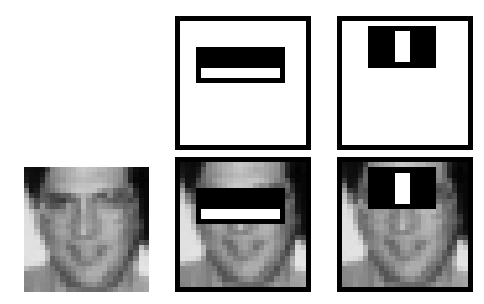
[Источник](https://habr.com/ru/companies/recognitor/articles/228195/)

### Интегральное изображение

Интегральное изображение представляется как:


$$ II(x,y) =   \sum_{i=0,j=0}^{i<x,j<y} I (i,j) $$


Значение в точке X,Y матрицы (II), полученной из исходного изображения (I) это сумма всех точек в прямоугольнике (0,0,X,Y). Тогда интеграл по любому прямоугольнику (ABCD) в изображении представим как:

$$ SumOfRect(ABCD) = II(A) + II(С) — II(B) — II(D) $$ 

Что даёт всего лишь 4 обращения к памяти и 3 математических действия для подсчёта суммы всех элементов прямоугольника вне зависимости от его размера. При расчёте других свёрток, отличных от свёрток примитивов Хаара, требуется количество действий пропорциональное квадрату размера примитива (если не рассчитывать через БПФ, что возможно не для любых паттернов).

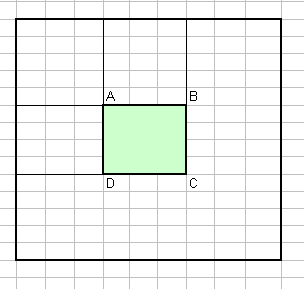
[Источник](https://robocraft.ru/computervision/536)

Одной из полезнейших особенностей интегрального представления является возможность очень быстро вычислить сумму пикселей произвольного прямоугольника (или любой другой фигуры, которую можно аппроксимировать несколькими прямоугольниками).

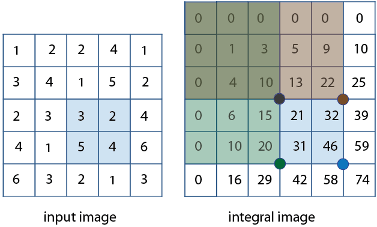

In [147]:
image=np.array([[1,2,2,4,1],[3,4,1,5,2],[2,3,3,2,4],[4,1,5,4,6],[6,3,2,1,3]],dtype='uint8')
image

array([[1, 2, 2, 4, 1],
       [3, 4, 1, 5, 2],
       [2, 3, 3, 2, 4],
       [4, 1, 5, 4, 6],
       [6, 3, 2, 1, 3]], dtype=uint8)

Проверим результат получения интергального изображения на картинке с помощью функции cv2.integral3

In [136]:
summ, _, _ = cv2.integral3(image)
summ

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  1,  3,  5,  9, 10],
       [ 0,  4, 10, 13, 22, 25],
       [ 0,  6, 15, 21, 32, 39],
       [ 0, 10, 20, 31, 46, 59],
       [ 0, 16, 29, 42, 58, 74]], dtype=int32)

или с помощью integral_image из skimage.transform

In [150]:
int_image = integral_image(image)
int_image

array([[ 1,  3,  5,  9, 10],
       [ 4, 10, 13, 22, 25],
       [ 6, 15, 21, 32, 39],
       [10, 20, 31, 46, 59],
       [16, 29, 42, 58, 74]], dtype=uint32)

### Задача

In [ ]:
#Напишите функцию рассчета средней яркости в выделенной прямоугольной области по исходному изображению
#аргументы функции: верхний левый угол и правый нижний угол выбранной прямоугольной области интереса
'''
ваш код
'''

In [ ]:
#Напишите функцию рассчета средней яркости для выбранной прямоугольной области на исходном изображении по интегральному изображению
#аргументы функции: верхний левый угол и правый нижний угол выбранной прямоугольной области интереса
'''
ваш код
'''

In [ ]:
#Оцените вычислительную сложность похода №1 и подхода №2

### Применение фильтра Хаара к интегральному изображению

In [146]:
from skimage.feature import haar_like_feature
from skimage.transform import integral_image

img = np.random.randint(0, 256, (24,24))
int_image = integral_image(img)

total = 0
for feature_type in ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']:
    '''
    Параметры haar_like_feature
    
    int_image: Интегральное изображение, для которого необходимо вычислить признаки  
    r: Координата строки верхнего левого угла окна обнаружения  
    c: Координата столбца верхнего левого угла окна обнаружения  
    width: Ширина окна обнаружения. 
    height: Высота окна обнаружения
    feature_type: тип примитива
    '''
    r, c = 0, 0
    width, height = int_image.shape[1], int_image.shape[0]
    #Каждое значение в features равно вычитанию сумм положительных и отрицательных прямоугольников
    features = haar_like_feature(int_image, r, c, width, height, feature_type)
    print(f"{feature_type}: {len(features)}")
    total += len(features)
print("\ntotal:", total)

type-2-x: 43200
type-2-y: 43200
type-3-x: 27600
type-3-y: 27600
type-4: 20736

total: 162336


### Применение каскада Хаара для детектирования лица

In [129]:
# OpenCV program to detect face in real time
# import libraries of python OpenCV 
# where its functionality resides
import cv2 

# load the required trained XML classifiers
# https://github.com/Itseez/opencv/blob/master/
# data/haarcascades/haarcascade_frontalface_default.xml
# Trained XML classifiers describes some features of some
# object we want to detect a cascade function is trained
# from a lot of positive(faces) and negative(non-faces)
# images.
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# capture frames from a camera
cap = cv2.VideoCapture(0)

# loop runs if capturing has been initialized.
while 1: 

    # reads frames from a camera
    ret, img = cap.read() 

    # convert to gray scale of each frames
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detects faces of different sizes in the input image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        # To draw a rectangle in a face 
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2) 
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

    # Display an image in a window
    cv2.imshow('img',img)

    # Wait for Esc key to stop
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

# Close the window
cap.release()

# De-allocate any associated memory usage
cv2.destroyAllWindows() 

Интнресная [статья](https://habr.com/ru/articles/504288/) на Хабре по визуализации каскада Хаара 

## 2. Инвариантные признаки (HOG)

"Гистограмма ориентированного градиента" (HOG) популярен для обнаружения объектов.

Обзор алгоритма:
1. Глобальная нормализация изображения
2. Вычисление градиентного изображения по x и y
3. Вычисление градиентных гистограмм
4. Нормализация по блокам
5. Уплощение в вектор признаков

На первом этапе применяется дополнительная глобальная нормализация изображения, которая предназначена для уменьшения влияния эффектов освещения. На втором этапе вычисляются градиенты изображения первого порядка. Они фиксируют контур, силуэт и некоторую текстурную информацию, обеспечивая дополнительную устойчивость к изменениям освещения.Третий этап направлен на создание кодировки, которая чувствительна к локальному содержанию изображения, оставаясь устойчивой к небольшим изменениям позы или внешнего вида. Четвертый этап вычисляет нормализацию, которая берет локальные группы областей и номализует их результаты перед переходом к следующему этапу. На последнем этапе дескрипторы HOG собираются из всех блоков в объединенный вектор признаков для использования в классификаторе.

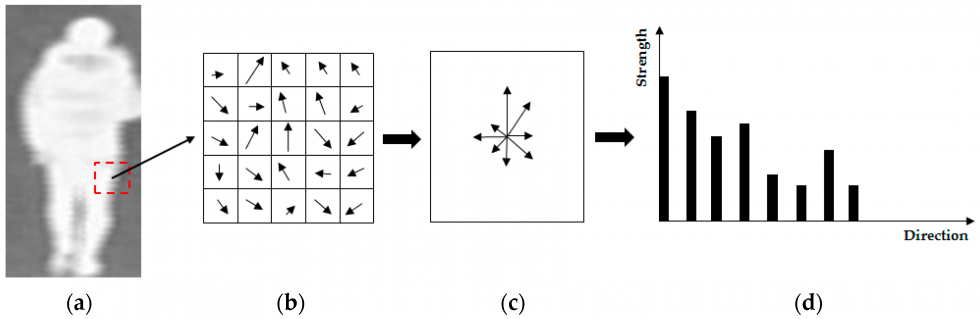

In [205]:
image = data.astronaut()
print("Разменость изображения {}x{}".format(image.shape[0],image.shape[1]))

features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1, feature_vector= True)
print("Длина вектора признаков {}".format(features.shape[0]))

Разменость изображения 512x512
Длина вектора признаков 8192


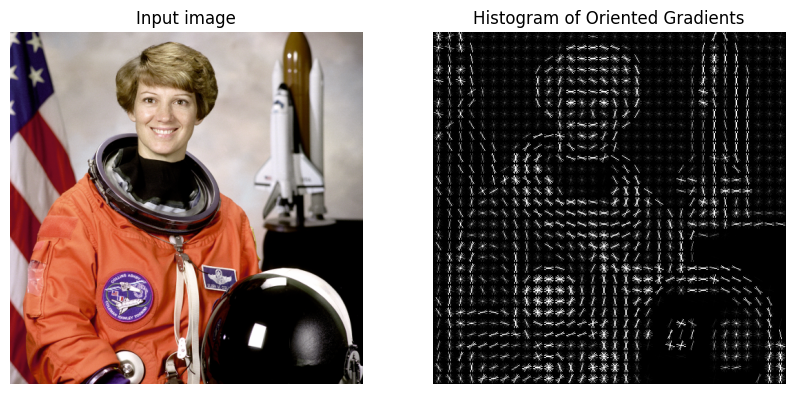

In [158]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### Задача

In [ ]:
#Напишите формулу которая рассчитает длину внетора призакнов с учетом параметрров HOG, указанных выше
'''
ваш код
'''

### Применение

Координаты прямоугольника, содержащего лицо вформате (top, right, bottom, left) (142, 498, 409, 230)


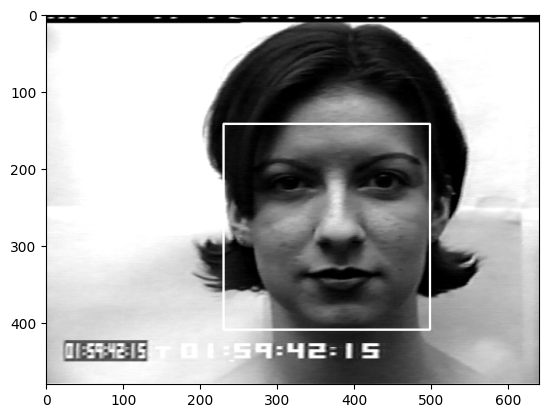

In [17]:
# Загружаем библиотеку с детектором лиц, предварительно установив !pip install face_recognition # GPU active needed
import face_recognition as fr
import cv2
image = cv2.imread("images\S010_001_00000001.png")

image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# Определяем координаты премоугольника, в котором нашлось лицо
face_loc = fr.face_locations(img = image, model='hog')[0]
print("Координаты прямоугольника, содержащего лицо вформате (top, right, bottom, left) {}".format(face_loc))

# Blue color in BGR
color = (255, 0, 0)

image = cv2.rectangle(image, (face_loc[1], face_loc[0]), (face_loc[3], face_loc[2]), color, 2)

plt.imshow(image, cmap = 'gray')
plt.show()

## 3. Фильтры Габора

### Операция свертки

*Свертка (Convolutional, Conv)* - это наложение на разные участки изображения фильтров (kernel) чтобы получить карту активаций, которая показывает насколько сильно фильтр похож на участок изображения. Похожесть определяется как скалярное произведение.

*Ядро свертки (Kernel)* - матрица для размытия, выделения границ изображения и других эффектов. 

*Область интереса (ROI)* - выделенная область изображения для произведения операций с ней.

*Паддинг (Padding)* -  дополнение изображения "рамкой" из пикселей, чтобы после свертки сохранился исходный размер изображения.

*Скользящее окно (Sliding Window)* - используется для выполнения необходимой операции над определенным размером окна матрицы. Скользящие окна начинаются с 1-го элемента и смещаются вправо на один элемент (или заданное число - stride), а длина окна изменяется в зависимости от решаемой задачи (kernel_size).

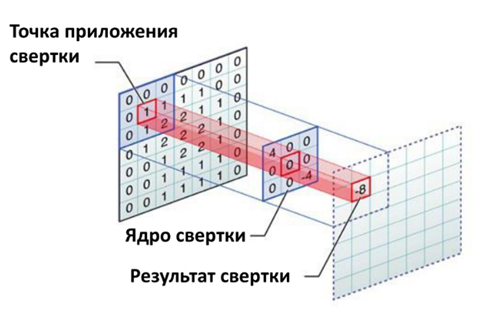

In [49]:
#Функция для выполнения операции свертки
def convolve(image, kernel):
    #вычисляем размерность входного изображения
    (iH, iW) = image.shape[:2]
    #вычисляем размерность ядра свертки
    (kH, kW) = kernel.shape[:2]
    #Определяе размер паддинга
    pad = (kW - 1) // 2
    #выполняет паддинг
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    #создаем пустое изображение по размерности ияходного
    output = np.zeros((iH, iW), dtype="float32")
    
    #реализация скользящеге окна
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            #выбор области интереса (области изображения для выполнения операции свертки)
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            #свертка с roi
            k = (roi * kernel).sum()
            #запись результата свертки в пустое изображение по индексу соответствющему шагу скользящего окна
            output[y - pad, x - pad] = k
            
    #приведение диапазона интенсивности изображения к диапазону от 0 до 255
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
    
    return output

(-0.5, 99.5, 99.5, -0.5)

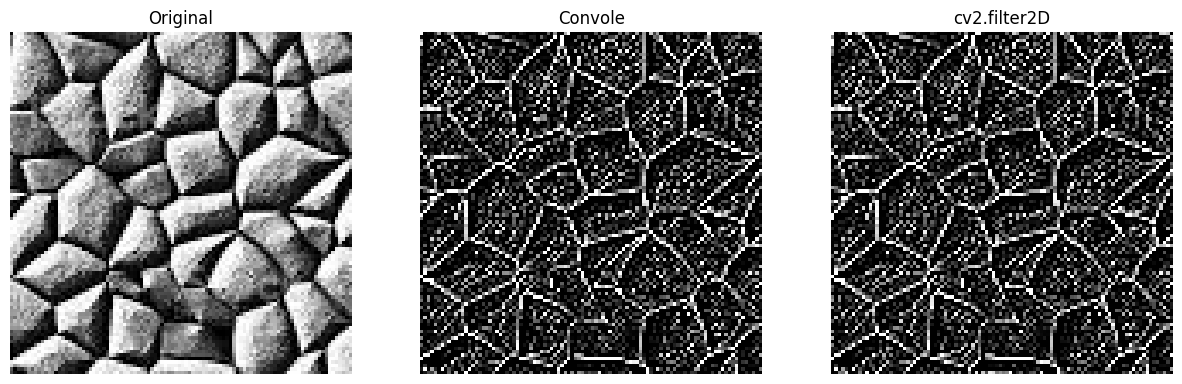

In [50]:
#Загружаем изображение
image = cv2.imread("image2.png")
#Переводим изображение в серое
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Выбираем ядро свертки
kernel = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

#Выполняем операцию светки с функцией написанной выше 
convoleOutput = convolve(gray, kernel)
#Выполняем операцию светки с функцией мз библиотеки opencv
opencvOutput = cv2.filter2D(gray, -1, kernel)

#Визуализируем результат
fig, axs = plt.subplots(1, 3, figsize=(15,15))
axs[0].imshow(gray, cmap="gray")
axs[0].title.set_text(f'Original')
axs[0].axis("off")

axs[1].imshow(convoleOutput, cmap="gray")
axs[1].title.set_text(f'Convole')
axs[1].axis("off")

axs[2].imshow(opencvOutput, cmap="gray")
axs[2].title.set_text(f'cv2.filter2D')
axs[2].axis("off")


### Банк фильтров Габора для описания текстур

Фильтр Габора — линейный электронный фильтр, импульсная переходная характеристика которого определяется в виде гармонической функции, помноженной на гауссиан. При цифровой обработке изображений этот фильтр применяется для распознавания границ объектов.
Классический вид фильтра Габора представляет собой функцию

Real:

$$ h(x,y) = \exp(-\dfrac{x^2+y^2} {2σ^2})cos2pif (xsinθ+ysinθ) $$

Complex: 

$$ h(x,y) = \exp(-\dfrac{x^2+y^2} {2σ^2})exp(i (2pif (xsinθ+ysinθ))) $$

где x, y – координаты точки; σ – стандартное отклонение предполагаемого нормального распределения; f – частота; θ – ориентация фильтр

In [93]:
# функция формирования банка фильтров Габора
def GB(kernel_size):
    kmax = np.pi / 2
    sigma = 2 * np.pi
    f = np.sqrt(2)
    x0 = kernel_size / 2
    y0 = kernel_size / 2
    F = []

    for mu in range(8):
        for nu in range(5):
            temp_array = np.zeros((kernel_size, kernel_size), dtype=complex)
            for x in range(kernel_size):
                for y in range(kernel_size):
                    k = kmax / (f ** nu)
                    omega = mu * (np.pi / 8)
                    G = np.exp(-k ** 2 * ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
                    S = np.exp(1j * k * ((x - x0) * np.cos(omega) + (y - y0) * np.sin(omega)))
                    temp_array[x, y] = G*S

            F.append(temp_array)

    return F

In [94]:
# формирование банка фильтров Габора
F = GB(kernel_size = 20)

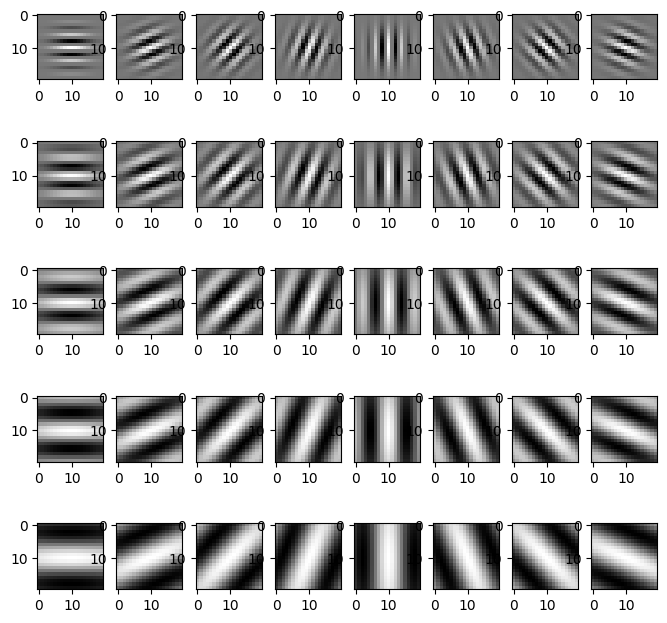

In [95]:
# по оси х - ориентация, по оси y - частота

# визуализация фильтров Габора
fig1, axs_1 = plt.subplots(5, 8, figsize=(8, 8))
for i in range(5):
    for j in range(8):
        axs_1[i,j].imshow(np.real(F[j*5+i]), cmap='gray')

plt.show()

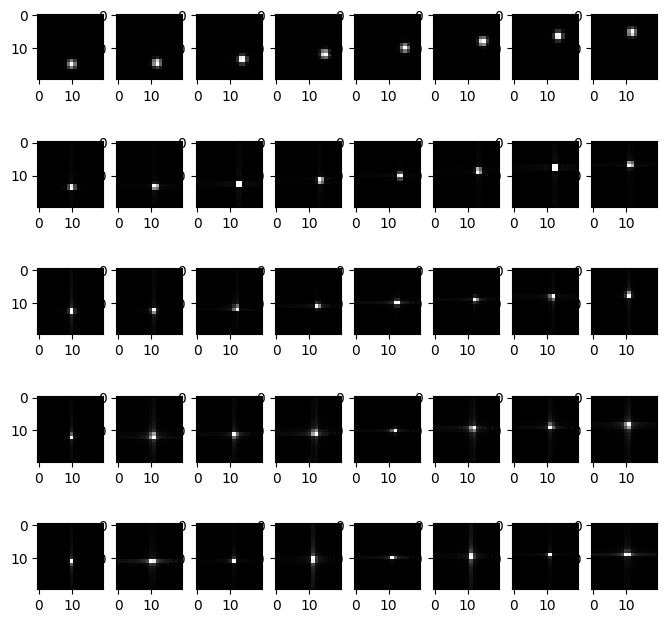

In [96]:
# визуализация Фурье-образов фильтров Габора
fig3, axs_3 = plt.subplots(5, 8, figsize=(8, 8))
for i in range(5):
    for j in range(8):
        axs_3[i,j].imshow(np.abs(np.fft.fftshift(np.fft.fft2(F[j*5+i]))), cmap='gray')

plt.show()

Обработка изображения фильтром Габора достигается путём усреднения значений обрабатываемого изображения по некоторой области в каждой точке. Соответственно, наложение фильтра Габора на изображение имеет вид:

$$ I'(x,y) = \dfrac{1} {n^2} \sum_{i=1}^{n} \sum_{j=1}^{n} I (x-\dfrac{n} {2}+i, y-\dfrac{n} {2}+j) G(i,j) $$

где:

I(x,y) — интенсивность исходного изображения в точке (x, y),

I'(x,y) — интенсивность нового изображения в точке (x, y),

G(i,j) — значение функции Габора.

Если отбросить синусоидальную составляющую функции в фильтре Габора, он выродится в фильтр Гауссова размытия (Gaussian Blur). Поэтому очевидно, что эти два фильтра имеют практически одинаковый алгоритм применения, различающийся в некоторых деталях.

### Задача

Дополните код для визуализации применения фильтров Габора к изображению

In [ ]:
#Загружаем изображение
img = Image.open('image2.png').convert('L')

# применение фильтров к исходному изображению
fig2, axs_2 = plt.subplots(5, 8, figsize=(8, 8))
for i in range(5):
    for j in range(8):
        # ваш код
        axs_2[i,j].imshow(np.real(rez_conv), cmap='gray')

plt.show()

In [ ]:
#Загружаем изображение
img = cv2.imread('image2.png')

#задайте параметры филтра Габора
ksize = # ваш код
sigma = # ваш код
theta = # ваш код
lambd = # ваш код
gamma = # ваш код

# примените функцию getGaborKernel из opencv для создания фильра
# примените gabor kernel к изображению
# визуализируйте изображение